# Notes

We provide this notebook for inference and visualizations. 

You can either load images from a dataloader(see Sec. 1) or from a local path(see Sec. 2).

Welcome to join [IDEA](https://idea.edu.cn/en)([中文网址](https://idea.edu.cn/))!

In [1]:
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

# 0. Initialize and Load Pre-trained Models

In [2]:
model_config_path = "config/DINO/DINO_4scale.py" # change the path of the model config file
model_checkpoint_path = "ckpts/checkpoint0023_4scale.pth" # change the path of the model checkpoint
# See our Model Zoo section in README.md for more details about our pretrained models.

In [3]:
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda' 
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# load coco names
with open('util/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

# 1. Visualize images from a dataloader
## 1.1 Load Datasets

In [5]:
args.dataset_file = 'coco'
args.coco_path = "../coco/" # the path of coco
args.fix_size = False

dataset_val = build_dataset(image_set='val', args=args)   

data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704,
    736,
    768,
    800
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.91s)
creating index...
index created!


## 1.2 Get an Example and Visualize it

In [6]:
image, targets = dataset_val[1]

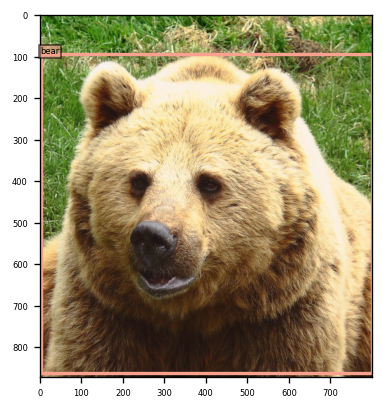

In [7]:
# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

## 1.3 Visualize Model Predictions

In [8]:
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

/workspace/orkspace/DINO/models/dino/position_encoding.py:95: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_tx = self.temperatureW ** (2 * (dim_tx // 2) / self.num_pos_feats)
/workspace/orkspace/DINO/models/dino/position_encoding.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_ty = self.temperatureH ** (2 * (dim_ty // 2) 

In [9]:
thershold = 0.3 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

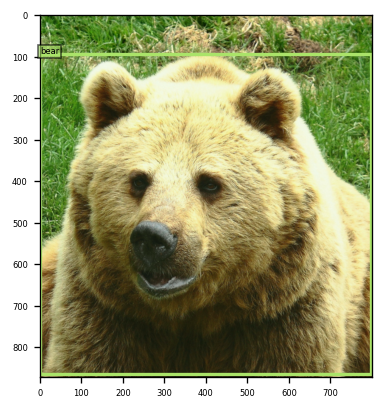

In [10]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

# 2. Visualize Custom Images

In [11]:
from PIL import Image
import datasets.transforms as T

In [12]:
image = Image.open("./figs/idea.jpg").convert("RGB") # load image

In [13]:
# transform images
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)

In [14]:
# predict images
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

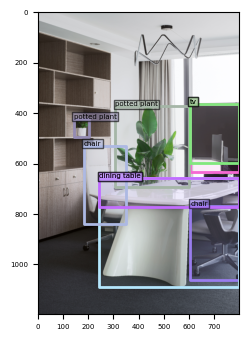

In [15]:
# visualize outputs
thershold = 0.3 # set a thershold

vslzr = COCOVisualizer()

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None, dpi=100)